# Import Modules

In [21]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import backend
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from ipynb.fs.full.utils import *

# Variables Initialization and Data Description

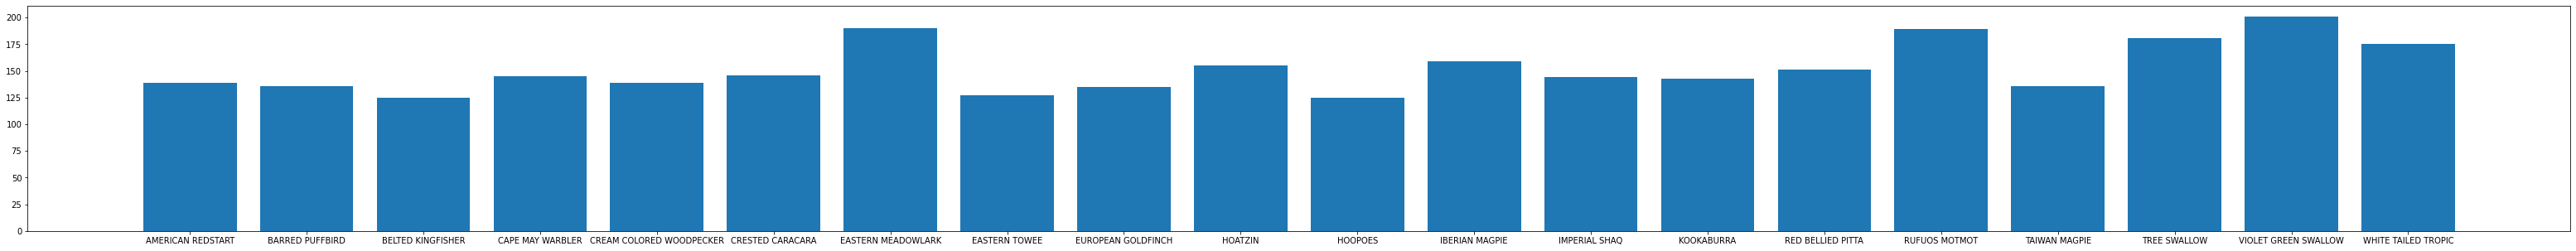

In [22]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

describe_data();

# Prepare Generators and Variables Initialization

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


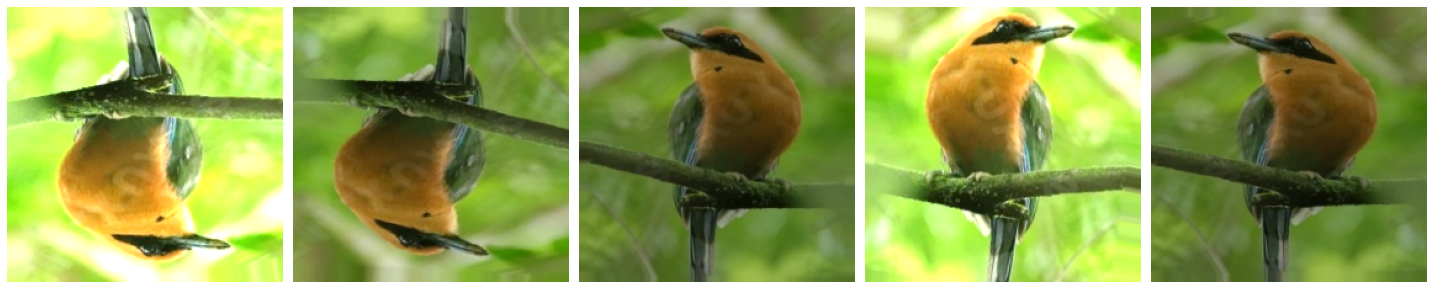

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.5, 2.0]
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Build model and train model

In [3]:
base_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Freezing the weights
for layer in base_vgg16.layers:
    layer.trainable = False

base_vgg16.summary();

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-08 20:09:38.994613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-08 20:09:38.994847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# use “get_layer” method to save the last layer of the network
last_layer = base_vgg16.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

x = Dropout(0.2)(x)

# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_vgg16.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='./checkpoints/birds.model.hdf5', save_best_only=True)

new_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

AdamHistory = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])

backend.clear_session()

new_model.compile(SGD(lr=0.01, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

SgdHistory = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30


2022-05-08 20:09:41.824442: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-08 20:09:42.323222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 17.8674 - accuracy: 0.3568

2022-05-08 20:10:38.276107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 58s 596ms/step - loss: 17.8674 - accuracy: 0.3568 - val_loss: 4.5524 - val_accuracy: 0.6600
Epoch 2/30
96/96 [==============================] - 65s 671ms/step - loss: 4.5738 - accuracy: 0.6468 - val_loss: 4.2527 - val_accuracy: 0.7200
Epoch 3/30
96/96 [==============================] - 71s 738ms/step - loss: 7.6112 - accuracy: 0.6393 - val_loss: 1.9357 - val_accuracy: 0.8300
Epoch 4/30
96/96 [==============================] - 73s 756ms/step - loss: 5.6644 - accuracy: 0.6948 - val_loss: 3.0293 - val_accuracy: 0.8300
Epoch 5/30
96/96 [==============================] - 72s 745ms/step - loss: 5.8006 - accuracy: 0.7369 - val_loss: 2.2918 - val_accuracy: 0.8000
Epoch 6/30
96/96 [==============================] - 86s 897ms/step - loss: 3.2960 - accuracy: 0.7777 - val_loss: 2.0540 - val_accuracy: 0.8300
Epoch 7/30
96/96 [==============================] - 102s 1s/step - loss: 3.2034 - accuracy: 0.8007 - val_loss: 3.1313 - val_accuracy: 0.8600
Epoch 8/30


/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30


2022-05-08 21:06:06.175809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.7602 - accuracy: 0.9184

2022-05-08 21:08:08.352854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 126s 1s/step - loss: 1.7602 - accuracy: 0.9184 - val_loss: 1.7551 - val_accuracy: 0.9400
Epoch 2/30
96/96 [==============================] - 126s 1s/step - loss: 1.3511 - accuracy: 0.9277 - val_loss: 2.1547 - val_accuracy: 0.9300
Epoch 3/30
96/96 [==============================] - 125s 1s/step - loss: 1.1046 - accuracy: 0.9457 - val_loss: 1.5007 - val_accuracy: 0.9400
Epoch 4/30
96/96 [==============================] - 124s 1s/step - loss: 1.3138 - accuracy: 0.9355 - val_loss: 1.6829 - val_accuracy: 0.9300
Epoch 5/30
96/96 [==============================] - 121s 1s/step - loss: 1.0992 - accuracy: 0.9418 - val_loss: 1.9374 - val_accuracy: 0.9400
Epoch 6/30
96/96 [==============================] - 118s 1s/step - loss: 1.2002 - accuracy: 0.9369 - val_loss: 1.5665 - val_accuracy: 0.9400
Epoch 7/30
96/96 [==============================] - 119s 1s/step - loss: 1.3457 - accuracy: 0.9326 - val_loss: 1.5544 - val_accuracy: 0.9400
Epoch 8/30
96/96 [======

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_60222/2526639165.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


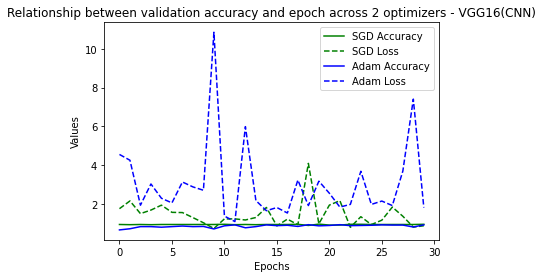

In [25]:
def plotOptimizer():
  fig = plt.figure()
  plt.plot(SgdHistory.history['val_accuracy'], 'g', label='SGD Accuracy')
  plt.plot(SgdHistory.history['val_loss'], 'g',  linestyle = 'dashed', label = 'SGD Loss')
  plt.plot(AdamHistory.history['val_accuracy'], 'b', label='Adam Accuracy')
  plt.plot(AdamHistory.history['val_loss'], 'b',  linestyle = 'dashed', label='Adam Loss')

  plt.title('Relationship between validation accuracy and epoch across 2 optimizers - VGG16(CNN)')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()
  return fig

fig = plotOptimizer()
fig.show()

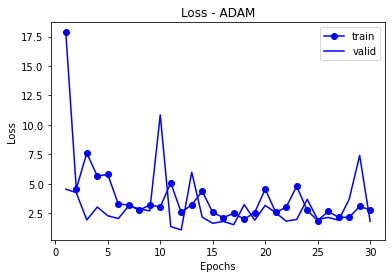

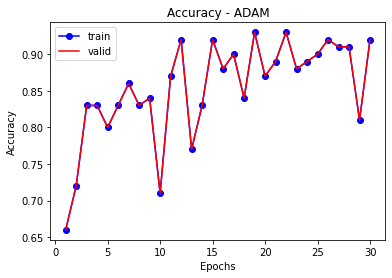

best val_acc: 0.9300000071525574 epoch: 18
best val_loss: 1.0901663303375244 epoch: 9


In [7]:
history_dict = AdamHistory.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["val_accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "b", marker = "o", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "b", marker = "o", label="train")
plt.plot(epochs, val_acc_values, "r", label="valid")
plt.title("Accuracy - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmax(val_loss_values))

In [1]:
history_dict = SgdHistory.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["val_accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "b", marker = "o", label="train")
plt.plot(epochs, val_loss_values, "r", label="valid")
plt.title("Loss - SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "b", marker = "o", label="train")
plt.plot(epochs, val_acc_values, "r", label="valid")
plt.title("Accuracy - SGD")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmax(val_loss_values))

NameError: name 'SgdHistory' is not defined

# Testing 

In [9]:
test_loss, test_acc = new_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 4s 905ms/step - loss: 1.4788 - accuracy: 0.9300
Test Accuracy: 0.9300000071525574


In [10]:
new_model.save('./models/cnn_model.h5')

## Running Predictions From Saved Model

In [18]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(os.listdir(train_path)))
  for i, pred in enumerate(predicted_arr):
    confidence = np.round(np.max(pred) * 100, 2)
    return (all_birds_cat[np.argmax(pred)], confidence)


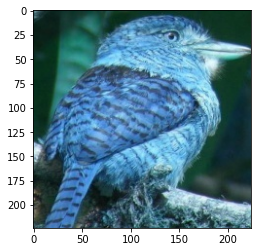

RUFUOS MOTMOT with 100.0% confidence


2022-05-08 22:12:55.310050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:

model = load_model('./models/cnn_model.h5')

predict_image_path = './dataset/20test/BARRED PUFFBIRD/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label, confidence = decode(predictions)

print(label + ' with ' + str(confidence) + '% confidence')